# Comparing NYC's First Floor Heights from the Building Elevation and Subgrade (BES) and National Flood Insurance Program (NFIP) Data Sets

Exploring the NYC Building Elevation and Subgrade (BES) Data Set in Python  

Author: Mark Bauer

In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import duckdb

import requests
import json
import time

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

In [2]:
# Printing verions of Python modules and packages with **watermark** - the IPython magic extension.
%reload_ext watermark
%watermark -v -p pandas,matplotlib,seaborn,duckdb

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

pandas    : 1.4.3
matplotlib: 3.5.2
seaborn   : 0.11.2
duckdb    : 0.10.0



# Data Set: Building Elevation and Subgrade (BES)

In [3]:
# create a DuckDB database instance
con = duckdb.connect()

# examine count of rows
con.sql("SELECT COUNT(*) AS count_rows FROM read_parquet('data/bes-data.parquet')").show()

┌────────────┐
│ count_rows │
│   int64    │
├────────────┤
│     861876 │
└────────────┘



In [4]:
bes_df = con.sql("SELECT * FROM read_parquet('data/bes-data.parquet')").df()

rows, cols = bes_df.shape
print('rows: {:,}\ncolumns: {}'.format(rows, cols))

# preview data
bes_df.head()

rows: 861,876
columns: 26


,the_geom,bin,bbl,borough,block,lot,address,z_grade,z_floor,subgrade,...,longitude,pluto_bbl,Council,BoroCD,CTLabel,BoroCT2020,NTA2020,NTAName,CDTA2020,CDTAName
0,POINT (-74.22274561187417 40.52134422844183),5128004,5075340353,5.0,7534.0,353,78 SAVO LOOP,29.428,32.332,N,...,-74.222746,5075340353,51,503,226.01,5022601,SI0304,Annadale-Huguenot-Prince's Bay-Woodrow,SI03,SI03 South Shore (CD 3 Approximation)
1,POINT (-74.24179250549321 40.52875316810818),5155392,5075960125,5.0,7596.0,125,72 CHART LOOP,25.366,26.703,N,...,-74.241793,5075960125,51,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
2,POINT (-74.24109012652094 40.528883822921635),5148808,5075960131,5.0,7596.0,131,40 TIDES LANE,36.172,38.902,N,...,-74.241090,5075960131,51,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
3,POINT (-74.24649640323727 40.507045708438184),5088274,5079150042,5.0,7915.0,42,328 MAIN STREET,69.897,72.459,N,...,-74.246496,5079150042,51,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
4,POINT (-74.24198032271697 40.51005666426356),5087850,5078680123,5.0,7868.0,123,309 SLEIGHT AVENUE,74.907,79.122,N,...,-74.241980,5078680123,51,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)


`z_grade`: The elevation of the building at it's lowest adjacent grade - the lowest point where the building touches the ground.

`z_floor`: The elevation of what is estimated to be the lowest actively used floor.

Definitions from the data dictionary.

In [5]:
# drop all records where z_floor is zero
bes_df = (
    bes_df
    .loc[(bes_df['z_floor'] != 0) & (bes_df['z_grade'] != 0)]
    .reset_index(drop=True)
)

print('new shape of data:', bes_df.shape)
bes_df.head()

new shape of data: (847837, 26)


,the_geom,bin,bbl,borough,block,lot,address,z_grade,z_floor,subgrade,...,longitude,pluto_bbl,Council,BoroCD,CTLabel,BoroCT2020,NTA2020,NTAName,CDTA2020,CDTAName
0,POINT (-74.22274561187417 40.52134422844183),5128004,5075340353,5.0,7534.0,353,78 SAVO LOOP,29.428,32.332,N,...,-74.222746,5075340353,51,503,226.01,5022601,SI0304,Annadale-Huguenot-Prince's Bay-Woodrow,SI03,SI03 South Shore (CD 3 Approximation)
1,POINT (-74.24179250549321 40.52875316810818),5155392,5075960125,5.0,7596.0,125,72 CHART LOOP,25.366,26.703,N,...,-74.241793,5075960125,51,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
2,POINT (-74.24109012652094 40.528883822921635),5148808,5075960131,5.0,7596.0,131,40 TIDES LANE,36.172,38.902,N,...,-74.241090,5075960131,51,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
3,POINT (-74.24649640323727 40.507045708438184),5088274,5079150042,5.0,7915.0,42,328 MAIN STREET,69.897,72.459,N,...,-74.246496,5079150042,51,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
4,POINT (-74.24198032271697 40.51005666426356),5087850,5078680123,5.0,7868.0,123,309 SLEIGHT AVENUE,74.907,79.122,N,...,-74.241980,5078680123,51,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)


Calculating Height from Building Adjacent Grade to First Floor.

In [6]:
# height from building floor to grade
bes_df['z_floor_grade'] = bes_df['z_floor'] - bes_df['z_grade']

# summary stats
bes_df['z_floor_grade'].describe()

count    847837.000000
mean          4.268165
std           3.087395
min         -50.487000
25%           2.015000
50%           3.627000
75%           6.571000
max          94.440000
Name: z_floor_grade, dtype: float64

In [7]:
# create a DuckDB database instance
con = duckdb.connect()
policies_df = con.sql("SELECT * AS FROM FROM read_parquet('data/nfip-data.parquet')").df()

# examine data
print('shape of data: {}'.format(policies_df.shape))
policies_df.head()

shape of data: (522387, 81)


,agricultureStructureIndicator,baseFloodElevation,basementEnclosureCrawlspaceType,cancellationDateOfFloodPolicy,condominiumCoverageTypeCode,construction,crsClassCode,buildingDeductibleCode,contentsDeductibleCode,elevatedBuildingIndicator,...,femaRegion,propertyState,reportedCity,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,id
0,False,13.0,0.0,None,N,False,NaN,0,0,False,...,2.0,NY,Currently Unavailable,10473,36005,36005000400,360050004004,40.8,-73.8,68a4de8a-0dec-4c7a-9ac6-5c387f379922
1,False,NaN,NaN,None,N,False,NaN,0,0,False,...,2.0,NY,Currently Unavailable,10475,36005,36005030200,360050302003,40.9,-73.8,7682eb23-b18b-4bdc-9272-7102baf543ee
2,False,NaN,2.0,None,N,False,NaN,None,0,False,...,2.0,NY,Currently Unavailable,10462,36005,36005009200,360050092002,40.8,-73.8,764a9457-b7d1-4f98-89fc-b24e4e3e4874
3,False,NaN,1.0,None,N,False,NaN,None,0,False,...,2.0,NY,Currently Unavailable,10465,36005,36005016000,360050160002,40.8,-73.8,311f657b-a7c2-4aaf-b5d7-764d5ebe4943
4,False,NaN,1.0,None,N,False,NaN,5,5,False,...,2.0,NY,Currently Unavailable,10474,36005,36005009300,360050093001,40.8,-73.9,e2c8075c-78ae-4129-91bb-de3b01fba09c


In [8]:
policies_df.loc[:, ['lowestAdjacentGrade', 'lowestFloorElevation']]

,lowestAdjacentGrade,lowestFloorElevation
0,16.5,17.8
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
522382,NaN,NaN
522383,NaN,NaN
522384,11.0,12.1
522385,NaN,NaN


In [9]:
policies_df.loc[:, ['lowestAdjacentGrade', 'lowestFloorElevation']].describe()

,lowestAdjacentGrade,lowestFloorElevation
count,113882.000000,114523.000000
mean,8.180638,16.167203
std,296.950443,241.535114
min,-99999.900000,-99.400000
25%,6.500000,7.300000
50%,8.200000,10.000000
75%,10.400000,12.500000
max,1813.700000,9995.000000


In [10]:
policies_df.loc[
    policies_df['lowestFloorElevation'].notnull(),
    ['lowestAdjacentGrade', 'lowestFloorElevation']
]

,lowestAdjacentGrade,lowestFloorElevation
0,16.5,17.8
19,8.0,11.0
28,2.7,12.7
39,18.0,15.7
46,8.0,17.8
...,...,...
522376,4.7,14.0
522378,11.8,13.4
522380,7.6,12.2
522384,11.0,12.1


In [11]:
policies_df['lowestAdjacentGrade'].value_counts()

 0.0     4045
 7.2     2352
 8.0     2275
 8.2     1997
 8.5     1962
         ... 
 39.1       1
-18.0       1
-2.3        1
-6.5        1
 20.2       1
Name: lowestAdjacentGrade, Length: 312, dtype: int64

In [12]:
policies_df.loc[
    policies_df['lowestAdjacentGrade'] == 0,
    ['lowestAdjacentGrade', 'lowestFloorElevation']
]

,lowestAdjacentGrade,lowestFloorElevation
341,0.0,18.6
342,0.0,18.6
630,0.0,15.0
631,0.0,15.0
656,0.0,16.6
...,...,...
521151,0.0,22.8
521881,0.0,2.3
522102,0.0,-0.5
522291,0.0,6.3


In [13]:
(policies_df
 .loc[
    (policies_df['lowestAdjacentGrade'] == 0) & (policies_df['lowestFloorElevation'] == 0)]
 .shape
)

(243, 81)

In [14]:
policies_df['lowestFloorElevation'].value_counts()

 10.1    2572
 10.2    2507
 10.0    1820
 10.4    1678
 11.2    1676
         ... 
-9.3        1
-8.2        1
 26.8       1
 33.8       1
-13.7       1
Name: lowestFloorElevation, Length: 424, dtype: int64

In [15]:
policies_df['first_floor_height'] = policies_df['lowestFloorElevation'] - policies_df['lowestAdjacentGrade']

policies_df.loc[
    policies_df['lowestFloorElevation'].notnull(),
    ['lowestAdjacentGrade', 'lowestFloorElevation', 'first_floor_height']
]

,lowestAdjacentGrade,lowestFloorElevation,first_floor_height
0,16.5,17.8,1.3
19,8.0,11.0,3.0
28,2.7,12.7,10.0
39,18.0,15.7,-2.3
46,8.0,17.8,9.8
...,...,...,...
522376,4.7,14.0,9.3
522378,11.8,13.4,1.6
522380,7.6,12.2,4.6
522384,11.0,12.1,1.1


In [16]:
policies_df.loc[:, ['first_floor_height']].describe()

,first_floor_height
count,113594.000000
mean,2.115173
std,297.280412
min,-1813.200000
25%,-0.900000
50%,0.500000
75%,3.800000
max,100011.600000


In [17]:
policies_df = (
    policies_df
    .loc[
        (policies_df['first_floor_height'].notnull())
        & (policies_df['first_floor_height'].between(-99, 99))]
    .reset_index(drop=True)
)

print('shape of data: {}'.format(policies_df.shape))
policies_df.head()

shape of data: (113541, 82)


,agricultureStructureIndicator,baseFloodElevation,basementEnclosureCrawlspaceType,cancellationDateOfFloodPolicy,condominiumCoverageTypeCode,construction,crsClassCode,buildingDeductibleCode,contentsDeductibleCode,elevatedBuildingIndicator,...,propertyState,reportedCity,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,id,first_floor_height
0,False,13.0,0.0,None,N,False,NaN,0,0,False,...,NY,Currently Unavailable,10473,36005,36005000400,360050004004,40.8,-73.8,68a4de8a-0dec-4c7a-9ac6-5c387f379922,1.3
1,False,17.0,2.0,None,N,False,NaN,1,0,True,...,NY,Currently Unavailable,10465,36005,36005027402,360050274020,40.8,-73.8,356d3442-5eb9-4453-8b68-e95ff18114cc,3.0
2,False,15.0,2.0,None,N,False,NaN,1,1,True,...,NY,Currently Unavailable,10464,36005,36005051600,360050516000,40.9,-73.8,be71cf40-60c4-4143-98dd-5a3c8382673d,10.0
3,False,14.0,2.0,None,N,False,NaN,0,0,False,...,NY,Currently Unavailable,10464,36005,36005051600,360050516001,40.9,-73.8,14ac0998-87a9-48ae-9fb6-a550f25050ce,-2.3
4,False,15.0,NaN,None,U,False,NaN,0,0,True,...,NY,Currently Unavailable,10464,36005,36005051600,360050516001,40.9,-73.8,d5d5d499-47c5-43c9-9cf4-46f6c4ace08d,9.8


In [18]:
policies_df.loc[:, ['first_floor_height']].describe()

,first_floor_height
count,113541.000000
mean,1.525469
std,5.004932
min,-92.200000
25%,-0.900000
50%,0.500000
75%,3.800000
max,83.200000


In [19]:
policies_df['first_floor_height'].value_counts()

 0.0     6712
 0.5     2073
 0.1     1997
 0.4     1834
 1.0     1812
         ... 
-11.3       1
-32.4       1
-7.4        1
-17.3       1
-40.2       1
Name: first_floor_height, Length: 909, dtype: int64

# Concatenate Data Sets Together

In [20]:
nfip = (
    policies_df
    .loc[:, ['id', 'first_floor_height']]
    .assign(source='nfip')
)

bes = (
    bes_df
    .loc[:, ['bin', 'z_floor_grade']]
    .rename(columns={'bin':'id', 'z_floor_grade':'first_floor_height'})
    .assign(source='bes')
)

distribution_df = pd.concat([nfip, bes], ignore_index=True)

distribution_df

,id,first_floor_height,source
0,68a4de8a-0dec-4c7a-9ac6-5c387f379922,1.300,nfip
1,356d3442-5eb9-4453-8b68-e95ff18114cc,3.000,nfip
2,be71cf40-60c4-4143-98dd-5a3c8382673d,10.000,nfip
3,14ac0998-87a9-48ae-9fb6-a550f25050ce,-2.300,nfip
4,d5d5d499-47c5-43c9-9cf4-46f6c4ace08d,9.800,nfip
...,...,...,...
961373,2066048,11.753,bes
961374,2066902,3.738,bes
961375,2083027,4.228,bes
961376,2072400,2.300,bes


In [21]:
distribution_df['source'].value_counts()

bes     847837
nfip    113541
Name: source, dtype: int64

In [22]:
distribution_df['source'].value_counts(normalize=True)

bes     0.881898
nfip    0.118102
Name: source, dtype: float64

In [23]:
distribution_df['id'].is_unique

True

In [24]:
distribution_df.groupby(by='source').describe()

first_floor_height                                                   \
                    count      mean       std     min    25%    50%    75%   
source                                                                       
bes              847837.0  4.268165  3.087395 -50.487  2.015  3.627  6.571   
nfip             113541.0  1.525469  5.004932 -92.200 -0.900  0.500  3.800   

               
          max  
source         
bes     94.44  
nfip    83.20

# Compare Lowest Floor Elevation Between Both Data Sets

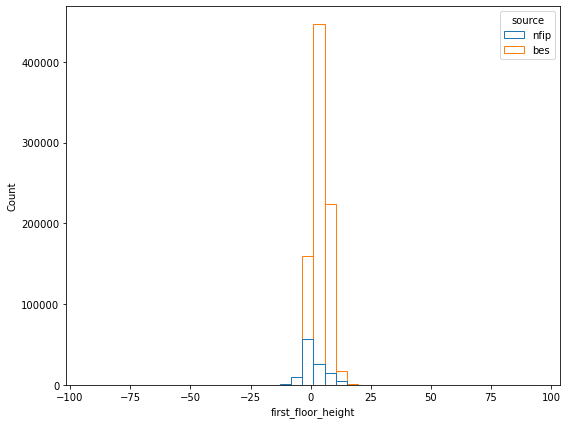

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(
    data=distribution_df,
    x="first_floor_height",
    bins=40,
    ax=ax,
    fill=False,
    hue="source",
)

plt.tight_layout()

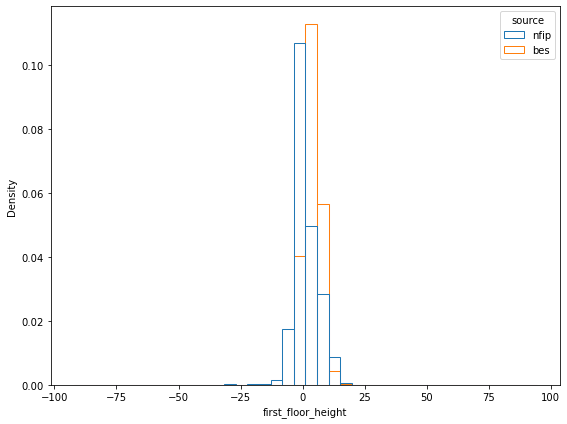

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(
    data=distribution_df,
    x="first_floor_height",
    bins=40,
    ax=ax,
    fill=False,
    hue="source",
    stat="density",
    common_norm=False
)

plt.tight_layout()

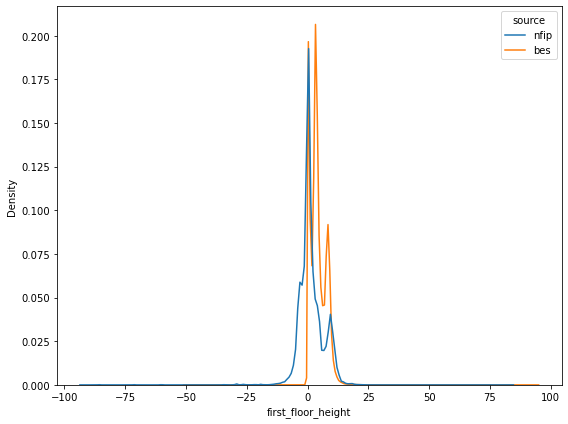

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.kdeplot(
    data=distribution_df,
    x="first_floor_height",
    ax=ax,
    hue="source",
    common_norm=False
)

plt.tight_layout()

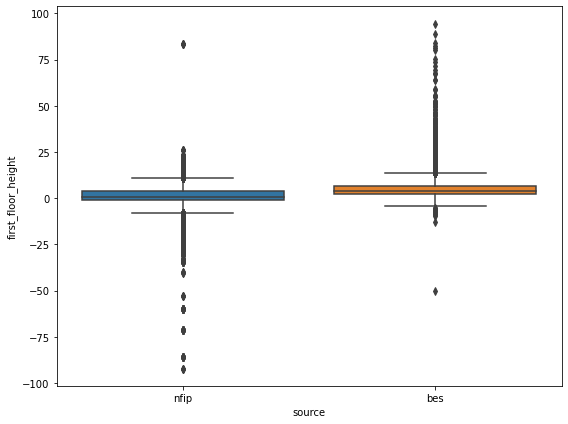

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(
    data=distribution_df,
    x="source",
    y="first_floor_height",
    ax=ax
)

plt.tight_layout()

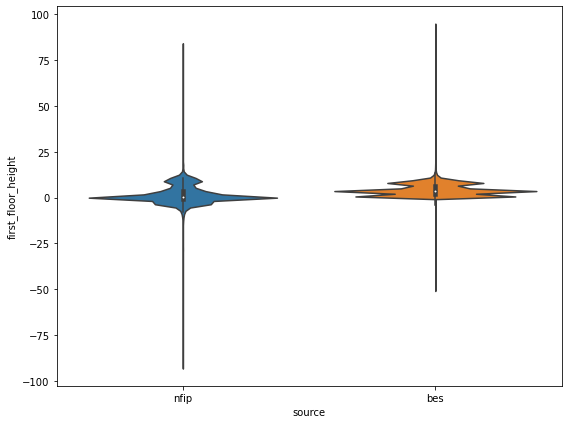

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.violinplot(
    data=distribution_df,
    x="source",
    y="first_floor_height",
    ax=ax
)

plt.tight_layout()

In [30]:
sample_df = distribution_df.loc[distribution_df['first_floor_height'].between(-10, 15)]

sample_df

,id,first_floor_height,source
0,68a4de8a-0dec-4c7a-9ac6-5c387f379922,1.300,nfip
1,356d3442-5eb9-4453-8b68-e95ff18114cc,3.000,nfip
2,be71cf40-60c4-4143-98dd-5a3c8382673d,10.000,nfip
3,14ac0998-87a9-48ae-9fb6-a550f25050ce,-2.300,nfip
4,d5d5d499-47c5-43c9-9cf4-46f6c4ace08d,9.800,nfip
...,...,...,...
961373,2066048,11.753,bes
961374,2066902,3.738,bes
961375,2083027,4.228,bes
961376,2072400,2.300,bes


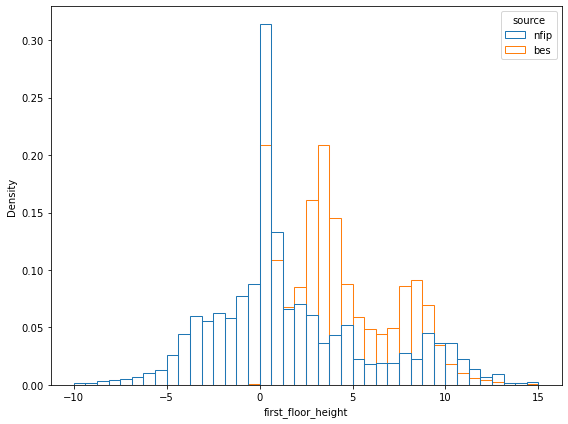

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(
    data=sample_df,
    x="first_floor_height",
    bins=40,
    ax=ax,
    fill=False,
    hue="source",
    stat="density",
    common_norm=False
)

plt.tight_layout()

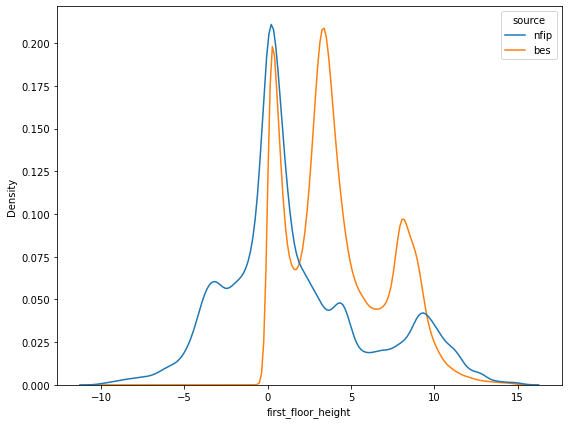

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.kdeplot(
    data=sample_df,
    x="first_floor_height",
    ax=ax,
    hue="source",
    common_norm=False
)

plt.tight_layout()

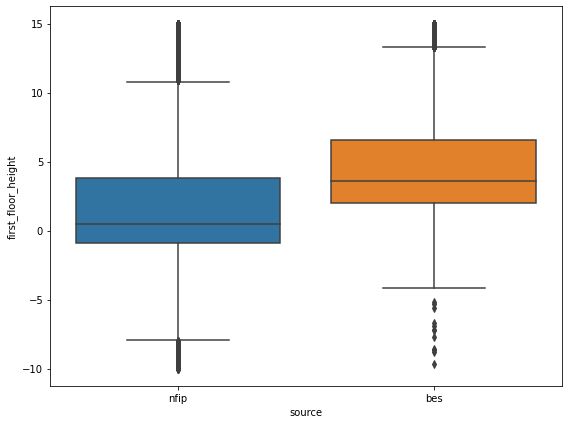

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(
    data=sample_df,
    x="source",
    y="first_floor_height",
    ax=ax
)

plt.tight_layout()

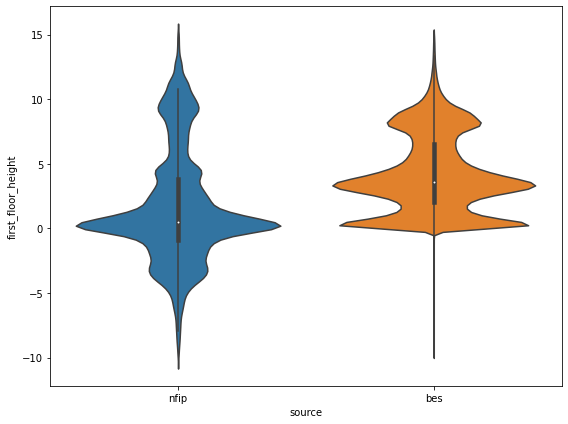

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.violinplot(
    data=sample_df,
    x="source",
    y="first_floor_height",
    ax=ax
)

plt.tight_layout()